# Import Libraries

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser
import html
import re
import emot
from nltk.tokenize import TweetTokenizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

# Datasets Download

In [2]:
df = pd.read_csv('DSL2122_january_dataset/development.csv')
df_val = pd.read_csv('DSL2122_january_dataset/evaluation.csv')

# Datasets Shape

In [3]:
print(f'Dev Shape: {df.shape}, Eval Shape: {df_val.shape}')

Dev Shape: (224994, 6), Eval Shape: (74999, 5)


# Drop Duplicates

In [4]:
wrong_duplicated_texts = df.groupby(by=['text']).mean()['sentiment'][((df.groupby(by=['text']).mean()['sentiment'] != 0) & (df.groupby(by=['text']).mean()['sentiment'] != 1))]

In [5]:
df = df[~df['text'].isin(wrong_duplicated_texts.keys())]

In [6]:
df.shape

(224363, 6)

In [7]:
df = df.drop_duplicates(subset=['user','text'])

In [8]:
df.shape

(223087, 6)

# Distribution Plot

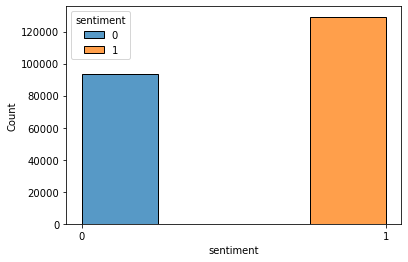

In [9]:

ax = sns.histplot(df,x='sentiment',hue='sentiment',multiple='dodge',bins=2)#,,2)
ax.set_xticks([0,1])
plt.savefig('preBalancing.pdf',dpi=300,bbox_inches='tight')

# Day of Week extraction

In [57]:
dates = [parser.parse(d,tzinfos={"PDT": -7 * 3600}) for d in df['date']]

dates_val = [parser.parse(d,tzinfos={"PDT": -7 * 3600}) for d in df_val['date']]

In [58]:
df['weekdays'] = pd.Series([d.weekday() for d in dates])

df_val['weekdays'] = pd.Series([d.weekday() for d in dates_val])

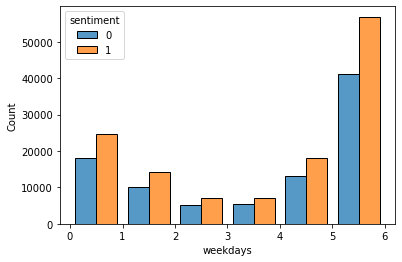

In [59]:
ax = sns.histplot(df,x='weekdays',hue='sentiment',multiple='dodge',shrink=.8,bins=6)
plt.savefig('weekDays.pdf',dpi=300)

In [13]:
weekdays = pd.get_dummies(df['weekdays'])

weekdays_val = pd.get_dummies(df_val['weekdays'])

# Users Extraction

In [14]:
users = df['user']

users_val = df_val['user']

In [15]:
users = pd.get_dummies(users)

users_val = pd.get_dummies(users_val)

In [16]:
users.shape, users_val.shape

((223087, 10647), (74999, 10647))

# Text Length Exploration

In [17]:
df['tweet_lens'] = [len(t) for t in df['text']] 

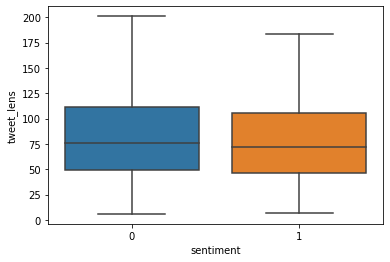

In [18]:


ax = sns.boxplot(x=df['sentiment'],y=df['tweet_lens'],showfliers=False)
plt.savefig('textLen.pdf',dpi=300)

# Decoding HTML symbols

In [19]:
texts = pd.Series(data=[html.unescape(t) for t in df['text']],index=df['text'].index)
target = df['sentiment'] 

texts_val = pd.Series(data=[html.unescape(t) for t in df_val['text']],index=df_val['text'].index)

# Lower case

In [20]:
texts = texts.str.lower()

texts_val = texts_val.str.lower()

# Remove URL

In [21]:
texts = texts.apply(lambda x: re.sub(r'https?:\/\/\S+','',x))

texts_val = texts_val.apply(lambda x: re.sub(r'https?:\/\/\S+','',x))

In [22]:
texts = texts.apply(lambda x: re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)','',x))

texts_val = texts_val.apply(lambda x: re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)','',x))

# Remove Mentions

In [23]:
texts = texts.apply(lambda x: re.sub(r'@[a-z1-10]+','',x))

texts_val = texts_val.apply(lambda x: re.sub(r'@[a-z1-10]+','',x))

# Remove Numbers

In [24]:
texts = texts.apply(lambda x: re.sub(r'\d+','',x))

texts_val = texts_val.apply(lambda x: re.sub(r'\d+','',x))

# Remove Underscore

In [25]:
texts = texts.apply(lambda x: re.sub(r'_+','',x))

texts_val = texts_val.apply(lambda x: re.sub(r'_+','',x))

# Substitute Multiple Punctuation

In [26]:
texts = texts.apply(lambda x: re.sub(r'(\.)\1+',' MULTIPLE_SOSPENSION',x))

texts_val = texts_val.apply(lambda x: re.sub(r'(\.)\1+',' MULTIPLE_SOSPENSION',x))

In [27]:
texts = texts.apply(lambda x: re.sub(r'(\?)\1+',' MULTIPLE_QUESTION',x))

texts_val = texts_val.apply(lambda x: re.sub(r'(\?)\1+',' MULTIPLE_QUESTION',x))

In [28]:
texts = texts.apply(lambda x: re.sub(r'(\!)\1+',' MULTIPLE_ESCLAMATION',x))

texts_val = texts_val.apply(lambda x: re.sub(r'(\!)\1+',' MULTIPLE_ESCLAMATION',x))

# Substitute Emoticons

In [29]:
emot_obj = emot.core.emot()

for i,row in zip(texts.index,texts.values):
    dct = emot_obj.emoticons(row)
    if dct['flag'] == True:
        for j, el in enumerate(dct['value']):
            texts[i] = texts[i].replace(el,'')
            texts[i] = texts[i] + dct['mean'][j]

# Tokenization

In [30]:
tokenizer = TweetTokenizer(reduce_len=True)

tokens = pd.Series([tokenizer.tokenize(t) for t in texts],index=df.index)

tokens_val = pd.Series([tokenizer.tokenize(t) for t in texts_val],index=df_val.index)

# Remove punctuation

In [31]:
punctuation = list(string.punctuation)

to_remove = punctuation

In [32]:
new_tokens = []
new_tokens_val = []

for tl in tokens:
     new_tokens.append([t for t in tl if (t not in punctuation) & (len(t) > 2)])
        
for tl in tokens_val:
     new_tokens_val.append([t for t in tl if (t not in punctuation) & (len(t) > 2)])
        
tokens = pd.Series(data=new_tokens,index=df.index)

tokens_val = pd.Series(data=new_tokens_val,index=df_val.index)

# Create Corpus

In [33]:
corpus = []
corpus_val = []

for t in tokens.values:
    corpus.append(" ".join(w for w in t))
    
for t in tokens_val.values:
    corpus_val.append(" ".join(w for w in t))
    
corpus = pd.Series(data=corpus,index=df.index)

corpus_val = pd.Series(data=corpus_val,index=df_val.index)

# TF-IDF Vectorization

In [34]:
vectorizer =TfidfVectorizer(use_idf=True,max_df=0.5,ngram_range=(1,2),max_features=60000,sublinear_tf=True)
vect = vectorizer.fit_transform(corpus)

vect_val = vectorizer.transform(corpus_val)

In [35]:
vect.shape, vect_val.shape

((223087, 60000), (74999, 60000))

# Concatenate Weekdays, Users and Texts Matrices

In [36]:
X = hstack((csr_matrix(weekdays),csr_matrix(users),vect))
X_val = hstack((csr_matrix(weekdays_val),csr_matrix(users_val),vect_val))

y = target

# Final Shape

In [37]:
print(f"X shape: {X.shape}, X_val shape: {X_val.shape}")

X shape: (223087, 70654), X_val shape: (74999, 70654)


# Model Building

In [38]:
models = []

In [39]:
lr = LogisticRegression(max_iter=10000,class_weight='balanced')

models.append(lr)

In [40]:
lsvc = LinearSVC(class_weight='balanced')

models.append(lsvc)

In [41]:
rc = RidgeClassifier(class_weight='balanced')

models.append(rc)

## Cross Validation

In [42]:
from sklearn.model_selection import cross_validate

results = []
for m in models:
    scores = cross_validate(m,X,y,cv=5,scoring=['accuracy','f1_macro','recall'])
    current = [round(scores['test_accuracy'].mean(),3),round(scores['test_f1_macro'].mean(),3),round(scores['test_recall'].mean(),3)]
    print(f"Model: {m}, ACC: {current[0]}, F1: {current[1]}, Recall: {current[2]}")
    results.append(current)

Model: LogisticRegression(class_weight='balanced', max_iter=10000), ACC: 0.831, F1: 0.828, Recall: 0.835
Model: LinearSVC(class_weight='balanced'), ACC: 0.817, F1: 0.813, Recall: 0.828
Model: RidgeClassifier(class_weight='balanced'), ACC: 0.803, F1: 0.799, Recall: 0.811


In [43]:
df_res = pd.DataFrame(data=results,columns=['Accuracy','F1 Macro','Recall'],index=['Logistic Regression','Linear SVC','Ridge Classifier'])

## Plot Results

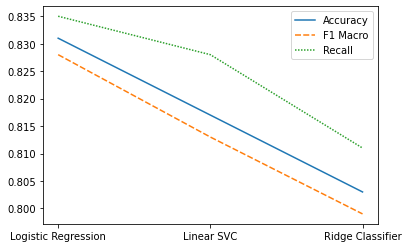

In [44]:
ax = sns.lineplot(data=df_res)
plt.savefig('models.pdf',dpi=300)

## Hyperparameters Tuning

In [45]:
parameters = {
    'solver':['liblinear','lbfgs','newton-cg','sag','saga'],
}

hgs = HalvingGridSearchCV(estimator=lr,param_grid=parameters,scoring='f1_macro',cv=5)
hgs.fit(X,y)

HalvingGridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=10000),
                    param_grid={'solver': ['liblinear', 'lbfgs', 'newton-cg',
                                           'sag', 'saga']},
                    scoring='f1_macro')

In [46]:
print(f'Best Score: {round(hgs.best_score_,3)}, Best Params: {hgs.best_params_}')

Best Score: 0.828, Best Params: {'solver': 'lbfgs'}


# Final Prediction

In [47]:
lr = LogisticRegression(max_iter=10000,class_weight='balanced',dual=False,solver='saga')

In [48]:
lr.fit(X,y)
y_pred = lr.predict(X_val)

## Model WordCloud

In [53]:
columns = vectorizer.get_feature_names_out()

In [54]:
coef = np.abs(lr.coef_[0])

In [55]:
dct = {columns[i]:coef[i] for i in range(0,len(columns))}

In [56]:
mask = np.array(Image.open("Twitter.png"))

wc = WordCloud(background_color='white',mask=mask)
wc.fit_words(dct)
plt.figure()
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.pdf',dpi=300)
plt.show()

TypeError: expected string or bytes-like object

# Generating Results csv

In [188]:
final_df = pd.DataFrame({'Id':df_val.index.to_list(),'Predicted':y_pred})

In [189]:
final_df.to_csv('resultProjectBest.csv',index=False)